In [1]:
import os
print("hello")

hello


In [3]:
from ultralytics import RTDETR
from PIL import Image
import zipfile
from pdf2image import convert_from_path

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
import io
from PIL import Image, ImageDraw
import numpy as np
import csv
import pandas as pd

import torch


import shutil
import re
import pytesseract
from openpyxl import Workbook
from openpyxl.utils import get_column_letter
# from openpyxl.drawing.image import Image as pyxl_image
import os

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

import subprocess

In [4]:

detection_model = RTDETR('table_detection.pt')
structure_model = RTDETR('table_structure.pt')


In [14]:
img_file = "image3.jpg"

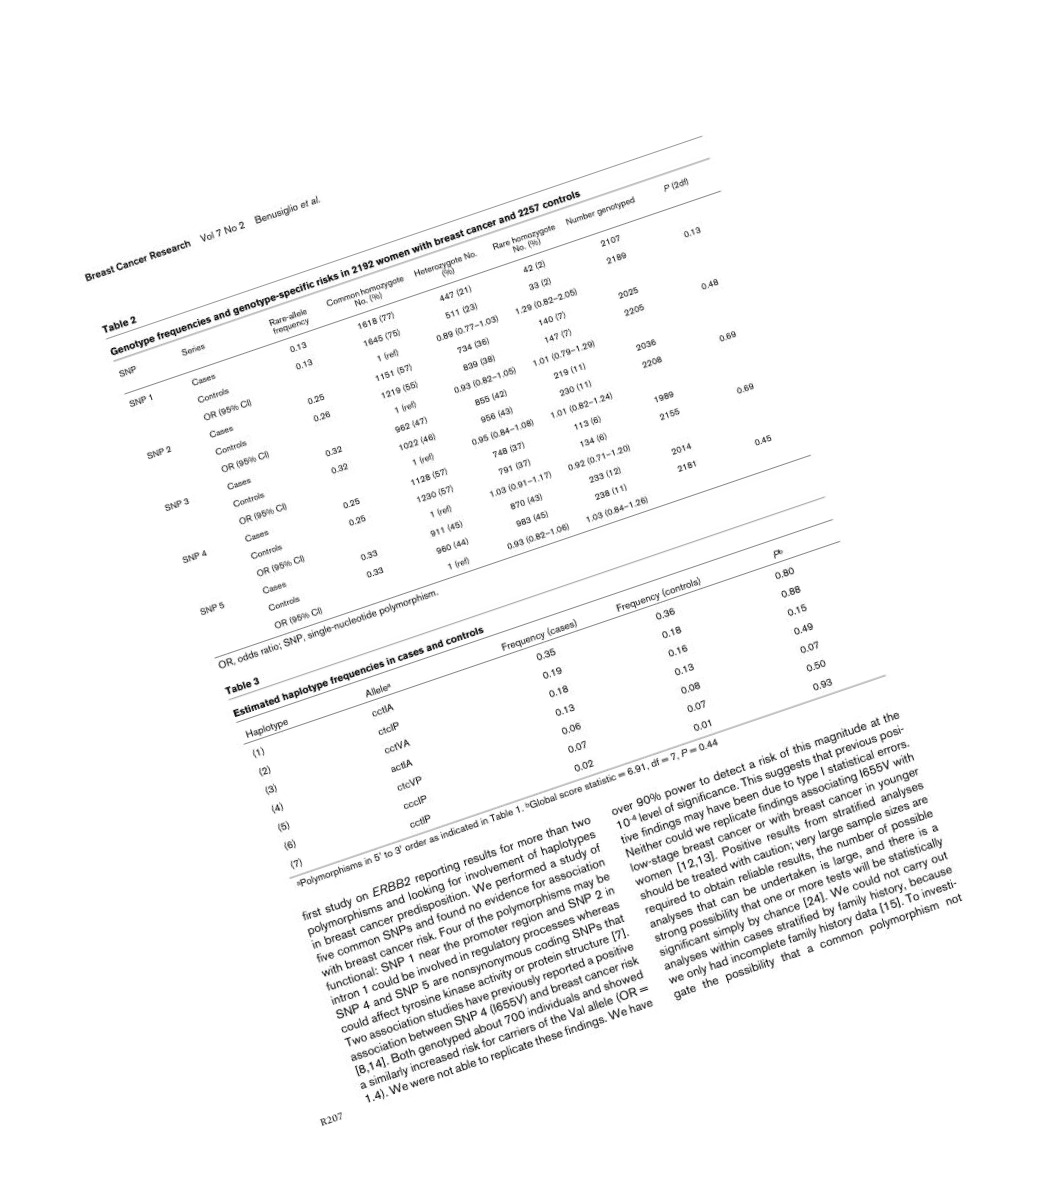

In [15]:
full_image = Image.open(img_file)
full_image

In [19]:
def get_rotation_angle(input_image):
    input_image = np.array(input_image)  
    gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle >= 45:
        angle = -90 + angle
            
    return angle

In [20]:
get_rotation_angle(full_image)

18.758649826049805

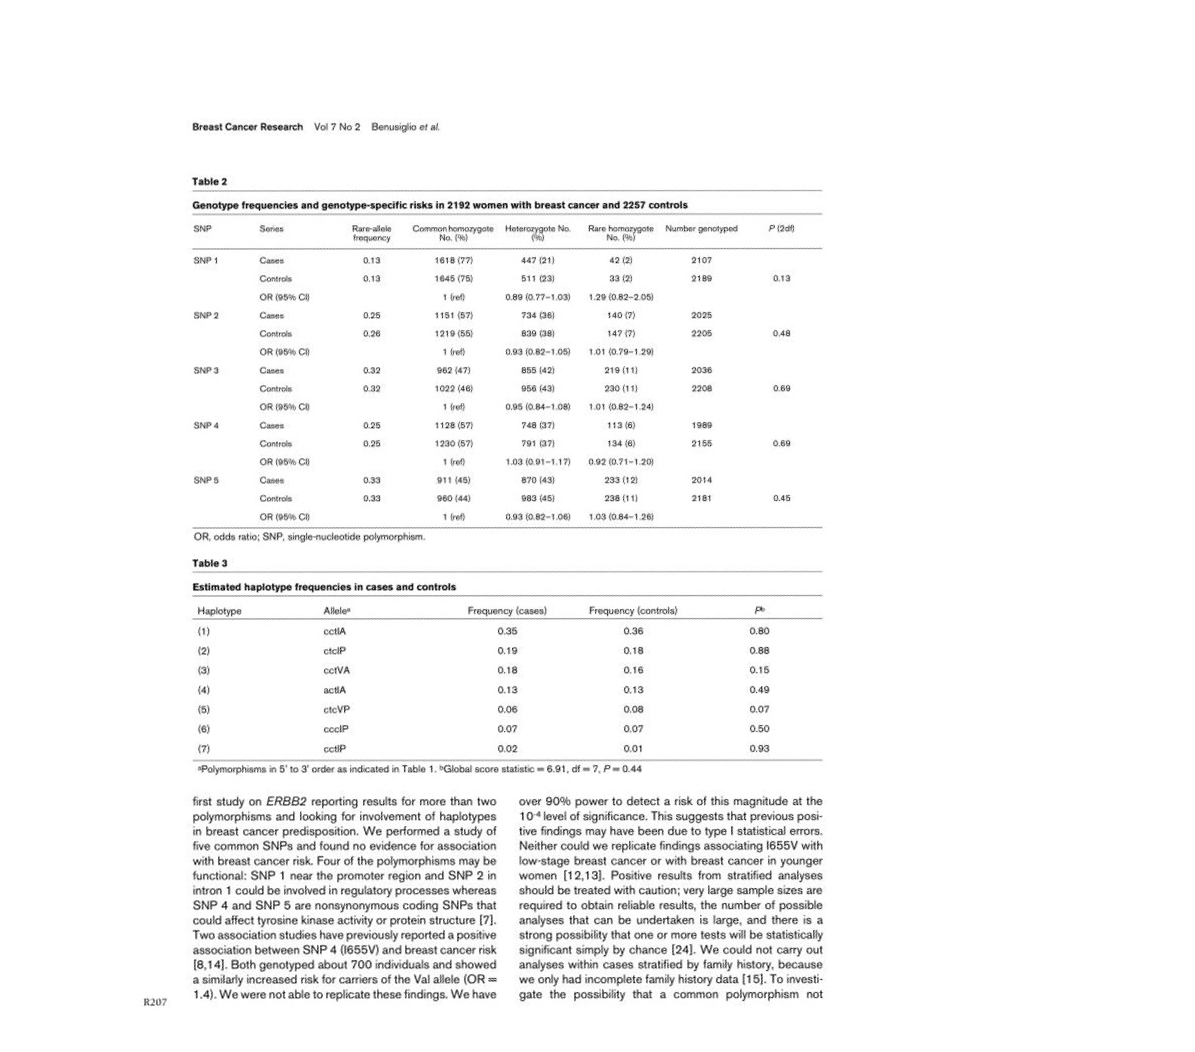

In [23]:
(h, w) = full_image.size
center = (w // 2, h // 2) 
M = cv2.getRotationMatrix2D(center, -get_rotation_angle(full_image), 1.0) 
rotated = cv2.warpAffine(np.array(full_image), M, (w, h),flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
rotated = Image.fromarray(rotated)

rotated

In [24]:
def table_detect(rotated):
          
    init_list = []
    final_list = []
    padding = 30
    img = rotated
        
    results = detection_model(img)
    for result in results:
        boxes = result.boxes  # Boxes object for bounding box outputs
        for box in boxes.xyxy:
            lis2 = []
            for coordinate in box:
                lis2.append(int(coordinate.item()))
            init_list.append(lis2)
    for box in init_list:
        xmin, ymin, xmax, ymax = box
        # Add padding
        xmin_pad = max(0, xmin - padding)
        ymin_pad = max(0, ymin - padding)
        xmax_pad = min(img.width, xmax + padding)
        ymax_pad = min(img.height, ymax + padding)
        final_list.append([xmin_pad, ymin_pad, xmax_pad, ymax_pad])
    return final_list

In [ ]:
def recognize_table(img):
    lis = []
    classes = []
    objects = []
    results = structure_model(img)

    for result in results:
        classes = result.boxes.cls.tolist()
        classes = [int(x) for x in classes]
        names = result.names
        boxes = result.boxes  # Boxes object for bounding box outputs
        for box in boxes.xyxy:
            lis2 = []
            for coordinate in box:
                lis2.append(int(coordinate.item()))
            lis.append(lis2)
                    
    for i in range(len(lis)):
        objects.append({'bbox': lis[i], 'label': names[classes[i]]})
    return objects

In [25]:
coordinates_lis = table_detect(rotated)
coordinates_lis


0: 640x640 2 tables, 1462.6ms
Speed: 8.0ms preprocess, 1462.6ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


[[162, 192, 822, 550], [165, 573, 797, 783]]

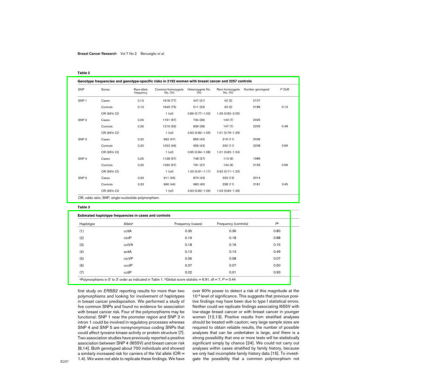

In [27]:
import cv2
import matplotlib.pyplot as plt

def draw_boxes_cv(image, boxes):
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        
        
img = np.array(rotated)


draw_boxes_cv(img, coordinates_lis)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')  
plt.show()

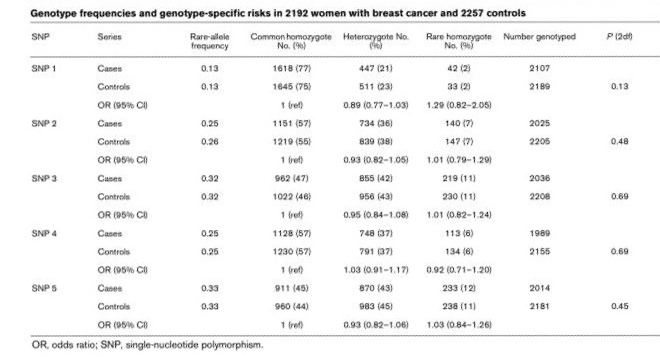

In [41]:
img_crop = rotated.crop(coordinates_lis[0])
img_crop

In [42]:
coords = recognize_table(img_crop)
coords


0: 480x480 1 table, 9 table columns, 16 table rows, 7 table spanning cells, 1 table column header, 1660.9ms
Speed: 2.2ms preprocess, 1660.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 480)


[{'bbox': [28, 26, 660, 326], 'label': 'table'},
 {'bbox': [415, 28, 496, 328], 'label': 'table column'},
 {'bbox': [238, 28, 335, 329], 'label': 'table column'},
 {'bbox': [334, 28, 415, 328], 'label': 'table column'},
 {'bbox': [496, 28, 588, 328], 'label': 'table column'},
 {'bbox': [76, 29, 170, 329], 'label': 'table column'},
 {'bbox': [29, 28, 76, 328], 'label': 'table column'},
 {'bbox': [170, 28, 237, 328], 'label': 'table column'},
 {'bbox': [29, 29, 659, 54], 'label': 'table row'},
 {'bbox': [29, 28, 659, 54], 'label': 'table column header'},
 {'bbox': [29, 54, 659, 75], 'label': 'table row'},
 {'bbox': [29, 277, 659, 295], 'label': 'table row'},
 {'bbox': [29, 295, 659, 313], 'label': 'table row'},
 {'bbox': [28, 312, 659, 328], 'label': 'table row'},
 {'bbox': [29, 75, 660, 94], 'label': 'table row'},
 {'bbox': [29, 258, 659, 277], 'label': 'table row'},
 {'bbox': [589, 28, 649, 328], 'label': 'table column'},
 {'bbox': [29, 112, 660, 130], 'label': 'table row'},
 {'bbox': 

In [ ]:
def draw_boxes_with_labels(image, boxes):
    for box in boxes:
        bbox = box['bbox']
        label = box['label']
        xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

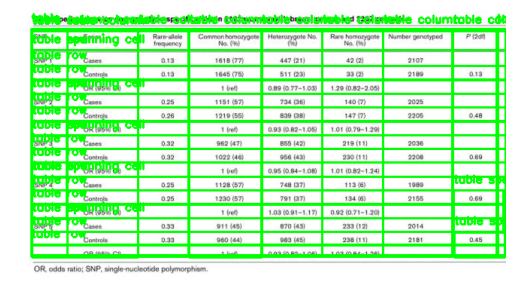

In [43]:
img_cv2 = cv2.cvtColor(np.array(img_crop), cv2.COLOR_RGB2BGR)

draw_boxes_with_labels(img_cv2, coords)

img= cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')  
plt.show()

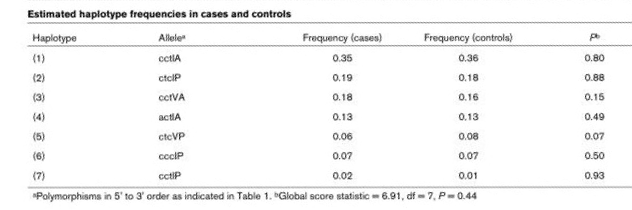

In [33]:
img_crop = rotated.crop(coordinates_lis[1])
img_crop

In [40]:
coords = recognize_table(img_crop)
coords


0: 480x480 1 table, 5 table columns, 8 table rows, 1 table column header, 1353.9ms
Speed: 13.7ms preprocess, 1353.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 480)


[{'bbox': [29, 27, 631, 178], 'label': 'table'},
 {'bbox': [400, 29, 546, 179], 'label': 'table column'},
 {'bbox': [30, 29, 115, 180], 'label': 'table column'},
 {'bbox': [243, 29, 400, 180], 'label': 'table column'},
 {'bbox': [115, 29, 243, 180], 'label': 'table column'},
 {'bbox': [545, 27, 631, 179], 'label': 'table column'},
 {'bbox': [30, 45, 631, 66], 'label': 'table row'},
 {'bbox': [29, 65, 631, 85], 'label': 'table row'},
 {'bbox': [29, 124, 631, 144], 'label': 'table row'},
 {'bbox': [29, 163, 631, 179], 'label': 'table row'},
 {'bbox': [29, 84, 631, 104], 'label': 'table row'},
 {'bbox': [30, 104, 631, 124], 'label': 'table row'},
 {'bbox': [29, 29, 630, 45], 'label': 'table row'},
 {'bbox': [29, 29, 630, 45], 'label': 'table column header'},
 {'bbox': [29, 143, 631, 163], 'label': 'table row'}]

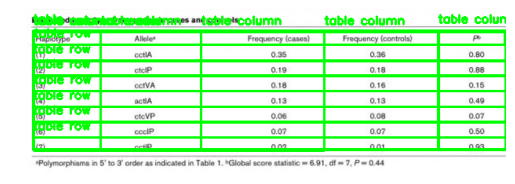

In [39]:
img_cv2 = cv2.cvtColor(np.array(img_crop), cv2.COLOR_RGB2BGR)

draw_boxes_with_labels(img_cv2, coords)

img= cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')  
plt.show()